# Fake News Detection

### Detect and Tackle Concept Drift



In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import spacy #tokenizer
from spacy.util import minibatch, compounding
import random

import os, glob
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, balanced_accuracy_score
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

https://github.com/zelros/cinnamon

In [2]:
df=pd.read_csv("combined_labeled_csv.csv") #combined csv for politfact datasets which were not labeled from https://github.com/KaiDMML/FakeNewsNet/tree/master/dataset
df

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,FAKE
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,FAKE
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,FAKE
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,FAKE
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,FAKE
...,...,...,...,...,...
23191,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,REAL
23192,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,REAL
23193,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,REAL
23194,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,REAL


In [3]:
fr=pd.read_csv('fake_or_real_news.csv') # fake_or_real_news dataset from https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news
fr

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


We create 2 separate dataframes for politifact, one contains the title of the article while the other the text

# Feature Selection and Preprocess 

In [4]:
df=df.drop('id',axis=1)


In [5]:
df=df.drop('tweet_ids',axis=1)


In [6]:
df=df.drop('news_url',axis=1)

In [7]:
df.shape


(23196, 2)

In [8]:
fr_text=fr.drop('title',axis=1)
fr_text.drop(fr.filter(regex="Unname"),axis=1, inplace=True)
fr_text

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [8]:
# function to check if the dataset is balanced
def create_distribution(dataFile):
    return sb.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes



<AxesSubplot:xlabel='label', ylabel='count'>

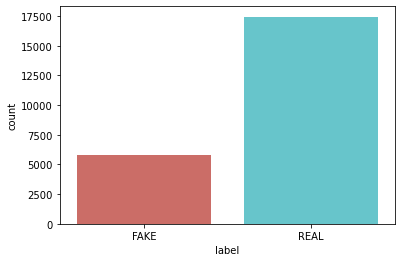

In [10]:
# check politifact
create_distribution(df)

<AxesSubplot:xlabel='label', ylabel='count'>

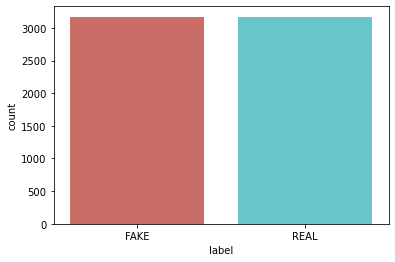

In [18]:
# check fr with text as feature
create_distribution(fr_text)

In [9]:
def data_qualityCheck(data):
    print("Checking data qualitites...")
    data.isnull().sum()
    data.info()  
    print("check finished.")


In [20]:
data_qualityCheck(df)

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23196 non-null  object
 1   label   23196 non-null  object
dtypes: object(2)
memory usage: 362.6+ KB
check finished.


In [21]:
data_qualityCheck(fr_text)

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6335 non-null   object
 1   label   6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB
check finished.


In [3]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [11]:
for x in range(len(df)) :
    corpus = []
    review = df['title'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    df['title'][x] = review      

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
label_train=df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df['title'], label_train, test_size=0.3, random_state=1)


In [13]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train,Y_train)

PassiveAggressiveClassifier()

Accuracy: 70.62%
Confusion matrix, without normalization


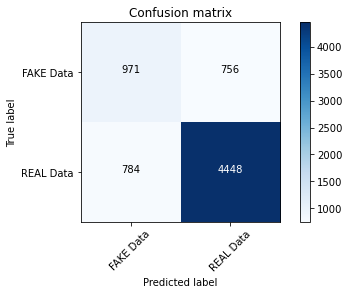

In [16]:

Y_pred = classifier.predict(tfidf_X_test)
score = metrics.balanced_accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

The accuracy isn't good at all, but it's logical since we didn't do almost any preprocessing and the classifier itself is pretty basic. Also the title doesn't really give out a lot of information for our model to train on.

### FOR fr dataset when title is dropped

In [31]:
for x in range(len(fr_text)) :
    corpus = []
    review = fr_text['text'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    fr_text['text'][x] = review      

In [33]:
label_train1=fr_text['label']
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(fr_text['text'], label_train1, test_size=0.3, random_state=1)


In [34]:
tfidf_v1 = TfidfVectorizer()
tfidf_X_train1 = tfidf_v1.fit_transform(X_train1)
tfidf_X_test1= tfidf_v1.transform(X_test1)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
classifier1 = PassiveAggressiveClassifier()
classifier1.fit(tfidf_X_train1,Y_train1)

PassiveAggressiveClassifier()

Accuracy: 93.43%
Confusion matrix, without normalization


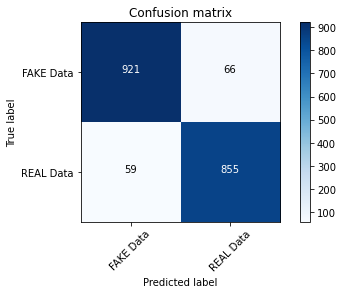

In [40]:
Y_pred1 = classifier1.predict(tfidf_X_test1)
score1 = metrics.balanced_accuracy_score(Y_test1, Y_pred1)
print(f'Accuracy: {round(score1*100,2)}%')
cm1 = metrics.confusion_matrix(Y_test1, Y_pred1)
plot_confusion_matrix(cm1, classes=['FAKE Data', 'REAL Data'])

We can see that training on text instead of the title is way better, but this is not the purpose of this notebook.

### FR dataset with titles

In [17]:
fr_title=pd.read_csv('fake_or_real_news.csv')
fr_title

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [18]:
fr_title=fr_title.drop('text',axis=1)
fr_title.drop(fr.filter(regex="Unname"),axis=1, inplace=True)
fr_title

,title,label
0,You Can Smell Hillary’s Fear,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matters,REAL
...,...,...
6330,State Department says it can't find emails fro...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...",REAL


In [19]:
for x in range(len(fr_title)) :
    corpus = []
    review = fr_title['title'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    fr_title['title'][x] = review  

In [20]:
label_train2=fr_title['label']
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(fr_title['title'], label_train2, test_size=0.3, random_state=1)


In [21]:
tfidf_v2 = TfidfVectorizer()
tfidf_X_train2 = tfidf_v2.fit_transform(X_train2)
tfidf_X_test2 = tfidf_v2.transform(X_test2)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
classifier2 = PassiveAggressiveClassifier()
classifier2.fit(tfidf_X_train2,Y_train2)

PassiveAggressiveClassifier()

Accuracy: 78.33%
Confusion matrix, without normalization


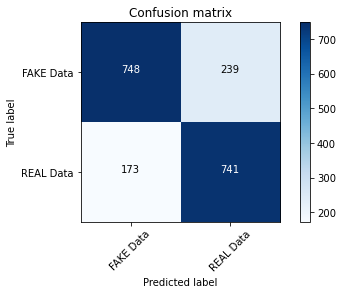

In [24]:
Y_pred2 = classifier2.predict(tfidf_X_test2)
score2 = metrics.accuracy_score(Y_test2, Y_pred2)
print(f'Accuracy: {round(score2*100,2)}%')
cm1 = metrics.confusion_matrix(Y_test2, Y_pred2)
plot_confusion_matrix(cm1, classes=['FAKE Data', 'REAL Data'])

In [30]:
np.shape(tfidf_X_test[:6334])

(6334, 14474)

In [33]:
np.shape(Y_test)

(6959,)

In [34]:
np.shape(Y_pred_df_fr)

(1901,)

In [29]:
np.shape(tfidf_X_test2)

(1901, 7492)

Accuracy: 38.45%
Confusion matrix, without normalization


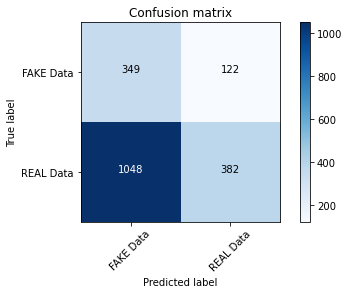

In [35]:
Y_pred_df_fr = classifier2.predict(tfidf_X_test[:1901, :7492])
score2 = metrics.accuracy_score(Y_test[:1901], Y_pred_df_fr)
print(f'Accuracy: {round(score2*100,2)}%')
cm1 = metrics.confusion_matrix(Y_test[:1901], Y_pred_df_fr)
plot_confusion_matrix(cm1, classes=['FAKE Data', 'REAL Data'])

In [50]:
Y_pred_df_fr

array(['FAKE', 'REAL', 'FAKE', ..., 'REAL', 'FAKE', 'FAKE'], dtype='<U4')

In [96]:
np.shape(tfidf_X_test)

(6959, 14474)

In [98]:
np.shape(Y_test2)

(1901,)

In [99]:
a=np.shape(tfidf_X_test)[0] - np.shape(tfidf_X_test2)[0]
b = np.shape(tfidf_X_test)[1] - np.shape(tfidf_X_test2)[1]
print(a)
print(b)


5058
6982


In [103]:
an_array = tfidf_X_test2
shape = np.shape(an_array)
padded_array = np.zeros((a+1000, b+1000))
padded_array[:shape[0],:shape[1]] = an_array.toarray()
print(padded_array)
shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(1901, 7492)

In [101]:
np.shape(padded_array)

(6058, 7982)

In [93]:

Y_pred_fr_df = classifier.predict(padded_array)
score = metrics.balanced_accuracy_score(Y_test2[:1901,], Y_pred_fr_df)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test2, Y_pred_fr_df)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

ValueError: X has 7982 features per sample; expecting 14474

# APO DW KAI KATW MAS ENDIAFEREI


In [51]:
### Combine the two datasets, using fr.title feature and df.text since they follow the same format.

In [5]:
result=pd.read_csv('result.csv')
result

,title,label
0,miley cyrus liam hemsworth secretly get married,FAKE
1,paris jackson cara delevingne enjoy night matc...,FAKE
2,celebrity join tax march protest donald trump,FAKE
3,cindy crawford daughter kaia gerber wear wig d...,FAKE
4,full list oscar nomination variety,FAKE
...,...,...
29526,state department say cant find email clinton s...,REAL
29527,p pb stand plutocratic pentagon,FAKE
29528,antitrump protester tool oligarchy information,FAKE
29529,ethiopia obama seek progress peace security ea...,REAL


In [17]:
data_qualityCheck(result)

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   29531 non-null  object
 1   label   29531 non-null  object
dtypes: object(2)
memory usage: 461.5+ KB
check finished.


<AxesSubplot:xlabel='label', ylabel='count'>

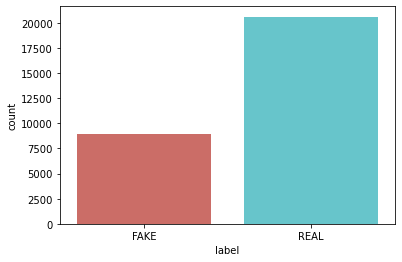

In [18]:
create_distribution(result)

In [19]:
shape1 = np.shape(df)
shape2 = np.shape(fr_title)
print(shape1,shape2)

(23196, 2) (6335, 2)


In [20]:
result.title

0        Did Miley Cyrus and Liam Hemsworth secretly ge...
1        Paris Jackson & Cara Delevingne Enjoy Night Ou...
2        Celebrities Join Tax March in Protest of Donal...
3        Cindy Crawford's daughter Kaia Gerber wears a ...
4            Full List of 2018 Oscar Nominations – Variety
                               ...                        
29526    State Department says it can't find emails fro...
29527    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
29528    Anti-Trump Protesters Are Tools of the Oligarc...
29529    In Ethiopia, Obama seeks progress on peace, se...
29530    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: title, Length: 29531, dtype: object

In [7]:

for x in range(len(result)) :
    corpus = []
    review = result['title'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', str(review))
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    result['title'][x] = review  

In [8]:
label_train3=result['label']
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(result['title'], label_train3, test_size=0.3, random_state=1)


In [9]:
tfidf_v3 = TfidfVectorizer()
tfidf_X_train3 = tfidf_v3.fit_transform(X_train3)
tfidf_X_test3 = tfidf_v3.transform(X_test3)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
classifier3 = PassiveAggressiveClassifier()
classifier3.fit(tfidf_X_train3,Y_train3)

PassiveAggressiveClassifier()

Accuracy: 75.86%
Confusion matrix, without normalization


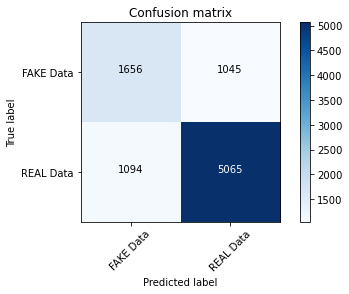

In [30]:
Y_pred3 = classifier3.predict(tfidf_X_test3)
score3 = metrics.accuracy_score(Y_test3, Y_pred3)
print(f'Accuracy: {round(score3*100,2)}%')
cm1 = metrics.confusion_matrix(Y_test3, Y_pred3)
plot_confusion_matrix(cm1, classes=['FAKE Data', 'REAL Data'])

ENTELEI H CINAMON DOULEUEUE MONO ME XGBOOSTCLASSIFIER OPOTE TO PANW EINAI MONO GIA SYGKRISH

In [31]:
tfidf_v3 = TfidfVectorizer()
tfidf_X_train3 = tfidf_v3.fit_transform(X_train3)
tfidf_X_test3 = tfidf_v3.transform(X_test3)

In [11]:
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import preprocessing


# load breast cancer data
#dataset = result
#X = dataset.title
#y = dataset.label


#result.label
# split data in train and valid dataset
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)

# introduce some data drift in valid by filtering with 'worst symmetry' feature  AYTO DE TO KANW GIATI THEWRHTIKA EXOUME HDH
#                                                                                DHMIOURGHSEI DRIFT
#y_valid = y_valid[X_valid.values > 0.3]
#X_valid = X_valid.loc[X_valid.values > 0.3, :].copy()
le = preprocessing.LabelEncoder()
le.fit(Y_train3)
Y_train3= le.transform(Y_train3)

clf1 = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
clf1.fit(X=tfidf_X_train3, y=Y_train3, verbose=10)
pred = clf1.predict(tfidf_X_test3)

le = preprocessing.LabelEncoder()
le.fit(Y_test3)
Y_test3= le.transform(Y_test3)

mse=balanced_accuracy_score(Y_test3, pred)

print(np.sqrt(mse))

0.8215576851569643


In [13]:
X_train_di = tfidf_X_train3.toarray()
Y_train_di = Y_train3
X_test_di = tfidf_X_test3.toarray()
Y_test_di = Y_test3

X_train_di_df= pd.DataFrame(X_train_di)
Y_train_di_df= pd.DataFrame(Y_train_di)
X_test_di_df= pd.DataFrame(X_test_di)
Y_test_di_df= pd.DataFrame(Y_test_di)



from pandas.util.testing import assert_frame_equal

X_train_di_df.reset_index(drop=True,inplace=True)
Y_train_di_df.reset_index(drop=True,inplace=True)
X_test_di_df.reset_index(drop=True,inplace=True)
Y_test_di_df.reset_index(drop=True,inplace=True)

C:\Users\Christos\AppData\Local\Temp/ipykernel_6208/944316578.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


EDW GYRNOUSE TO ERROR, EIXE NA KANEI ME TA SPARPSE MATRICES, OPOTE TA EKANA NP ARRAYS ENTELEI
TA PRINTARA GIA NA TA DEITE KIOLAS


TWRA EXW THEMA TO XGBOOST , OPOTE KANW AUTO XWRIS TO WRAPPER ALLA MOU EPISTREFEI ENA THEMA ME TO MEMORY ALLOCATION
https://stackoverflow.com/questions/70255620/xgboost-typeerror-predict-got-an-unexpected-keyword-argument-pred-contribs


EIDA KAI STACKOVERFLOW KAI LEGAN OTI FTAIEI H EKDOSH THS PYTHON(AN EINAI 32bit ALLA EMENA EINAI 64bit ARA DEN EINAI APO AUTO)



In [47]:
nX = tfidf_X_train3.astype(np.uint8)
ny= Y_train3
data =  xgb.DMatrix(nX, label = ny)
model = xgb.train({"learning_rate": 0.01, "max_depth": 4}, data)
model.predict(data, pred_contribs = True)

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5190497]], dtype=float32)

In [48]:
NX1=tfidf_X_train3.toarray()
NX2=tfidf_X_test3.toarray()


In [15]:
from cinnamon.drift import ModelDriftExplainer

# initialize a drift explainer with the built XGBClassifier and fit it on train
# and valid data
drift_explainer = ModelDriftExplainer(model=clf1)
drift_explainer.fit(X1=X_train_di_df, X2=X_test_di_df, y1=Y_train_di_df, y2=Y_test_di_df)

MemoryError: Unable to allocate 2.72 GiB for an array with shape (20671, 17645) and data type float64

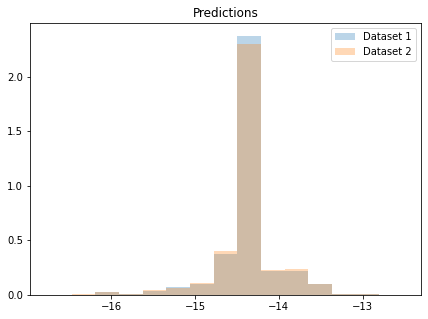

In [16]:
# Distribution of logit predictions
drift_explainer.plot_prediction_drift(bins=15)